# Classification with Neural Networks

## Import Libraries

Kita akan menggunakan beberapa library utama:
- tensorflow/keras: untuk membangun dan melatih neural network
- numpy: untuk operasi array dan matematika
- matplotlib: untuk visualisasi data dan hasil
- seaborn: untuk visualisasi yang lebih cantik
- sklearn: untuk metrics dan evaluasi model

In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.20.0
GPU Available: []


## Load Dataset
Kita akan menggunakan MNIST dataset sebagai contoh.
MNIST berisi 70,000 gambar angka tulisan tangan (0-9):
- 60,000 untuk training
- 10,000 untuk testing
- Ukuran gambar: 28x28 pixels (grayscale)

Pilih salah satu dataset di bawah dengan uncomment:


### Option 1 MNIST (Angka 0-9)

In [ ]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step


### Option 2 Fashion-MNIST (pakaian)

In [24]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Option 3 CIFAR-10 (objek warna)

In [ ]:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# y_train = y_train.flatten()
# y_test = y_test.flatten()
# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#                'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 156s 1us/step


### Print Data Shape

In [25]:
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nNumber of classes: {len(class_names)}")

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)

Number of classes: 10


## Visualisasi Data
Penting untuk melihat data kita sebelum melatih model.
Ini membantu kita memahami:
- Bagaimana gambar terlihat
- Apakah ada noise atau masalah
- Distribusi kelas (balanced/imbalanced)

### Tampilkan beberapa sample gambar

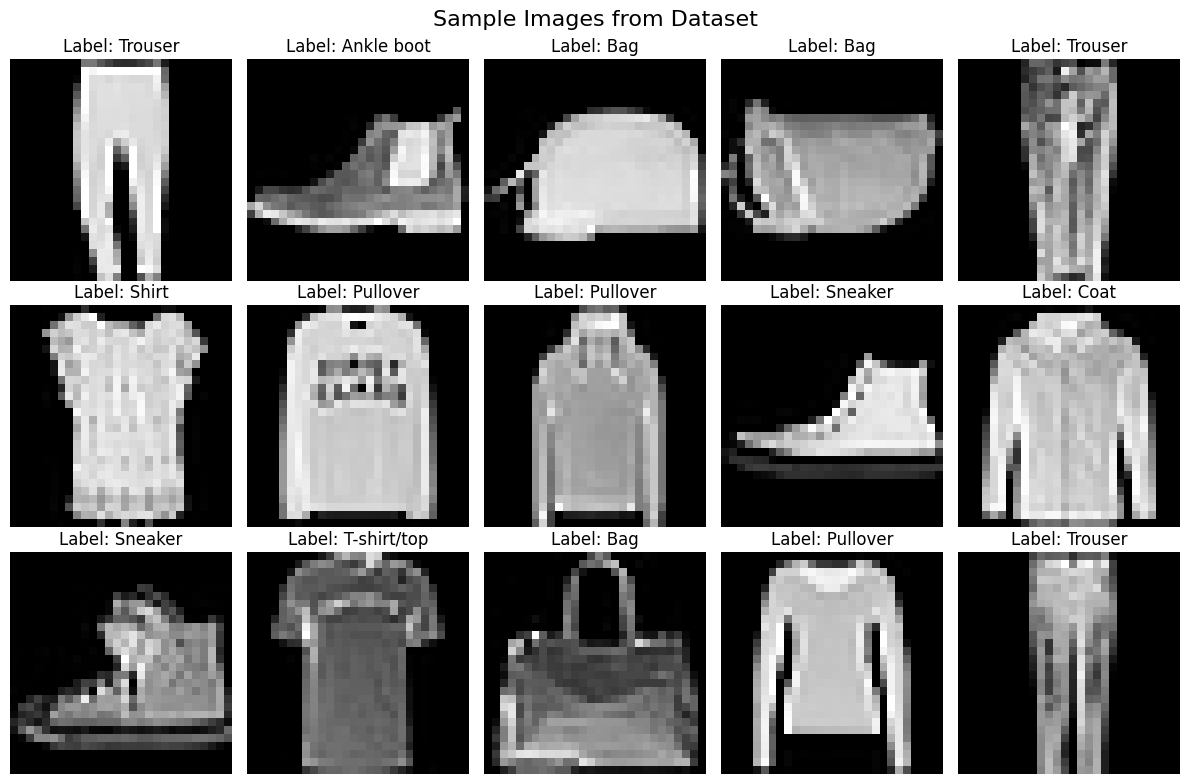

In [30]:
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
fig.suptitle('Sample Images from Dataset', fontsize=16)

for i, ax in enumerate(axes.flat):
    # Pilih random image
    idx = np.random.randint(len(x_train))
    
    # Plot image
    if len(x_train.shape) == 3:  # Grayscale
        ax.imshow(x_train[idx], cmap='gray')
    else:  # RGB
        ax.imshow(x_train[idx])
    
    ax.set_title(f'Label: {class_names[y_train[idx]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Visualisasi Distribusi kelas

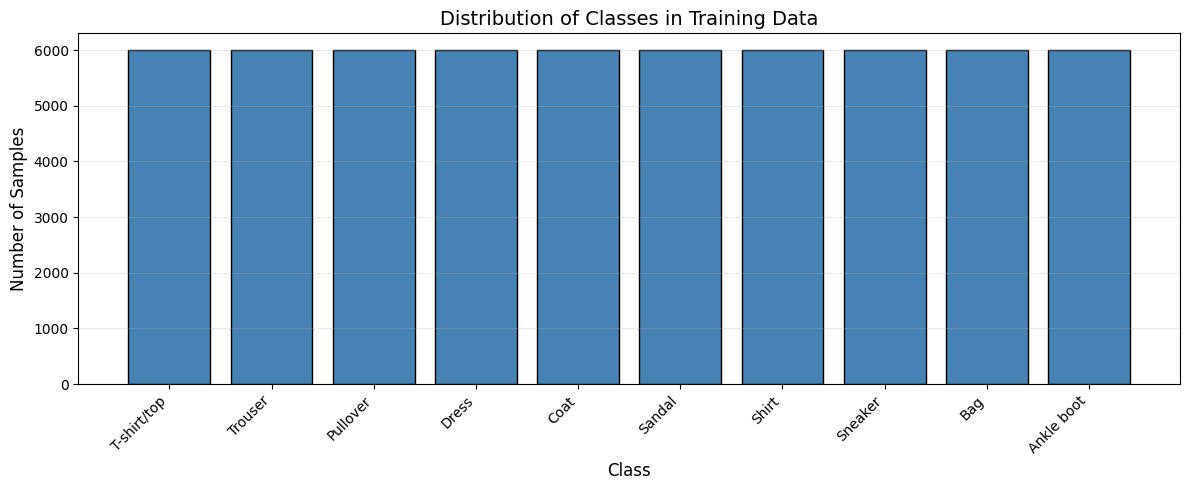


Class distribution:
  T-shirt/top: 6000 samples (10.0%)
  Trouser: 6000 samples (10.0%)
  Pullover: 6000 samples (10.0%)
  Dress: 6000 samples (10.0%)
  Coat: 6000 samples (10.0%)
  Sandal: 6000 samples (10.0%)
  Shirt: 6000 samples (10.0%)
  Sneaker: 6000 samples (10.0%)
  Bag: 6000 samples (10.0%)
  Ankle boot: 6000 samples (10.0%)


In [31]:
plt.figure(figsize=(12, 5))
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, color='steelblue', edgecolor='black')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Distribution of Classes in Training Data', fontsize=14)
plt.xticks(unique, class_names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nClass distribution:")
for i, count in enumerate(counts):
    print(f"  {class_names[i]}: {count} samples ({count/len(y_train)*100:.1f}%)")

## Data Preprocessing
Preprocessing adalah langkah penting sebelum training:

1. **Normalisasi**: Mengubah nilai pixel dari [0, 255] ke [0, 1]
   - Membantu model belajar lebih cepat
   - Mencegah gradient exploding/vanishing
   
2. **Reshape**: Menambahkan channel dimension jika perlu
   - CNN membutuhkan format (height, width, channels)
   
3. **Train-Validation Split**: Memisahkan data untuk validation
   - Validation set untuk monitoring overfitting

In [32]:
original_shape = x_train.shape[1:]

# Normalisasi pixel values ke [0, 1]
x_train = x_train.astype('float32') / 255.0
X_test = x_test.astype('float32') / 255.0

print(f"Pixel value range before normalization: [0, 255]")
print(f"Pixel value range after normalization: [{x_train.min():.2f}, {x_train.max():.2f}]")

Pixel value range before normalization: [0, 255]
Pixel value range after normalization: [0.00, 1.00]


In [33]:
# Reshape untuk CNN (tambahkan channel dimension jika grayscale)
if len(x_train.shape) == 3:  # Grayscale
    x_train = x_train.reshape(-1, x_train.shape[1], x_train.shape[2], 1)
    X_test = X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1)
    print(f"\nReshaped from {original_shape} to {x_train.shape[1:]}")


Reshaped from (28, 28) to (28, 28, 1)


In [34]:
# Split training data menjadi train dan validation
validation_split = 0.2
split_idx = int(len(x_train) * (1 - validation_split))

x_val = x_train[split_idx:]
y_val = y_train[split_idx:]
x_train = x_train[:split_idx]
y_train = y_train[:split_idx]

print(f"\nFinal data shapes:")
print(f"  Training: {x_train.shape}")
print(f"  Validation: {x_val.shape}")
print(f"  Test: {X_test.shape}")


Final data shapes:
  Training: (48000, 28, 28, 1)
  Validation: (12000, 28, 28, 1)
  Test: (10000, 28, 28, 1)


## Build Model - Simple FNN (Feedforward Neural Network) 
Kita mulai dengan model sederhana (Fully Connected):

Architecture:
- Flatten: mengubah gambar 2D menjadi 1D array
- Dense(128): hidden layer dengan 128 neurons + ReLU activation
- Dropout(0.2): randomly "matikan" 20% neurons untuk mencegah overfitting
- Dense(10): output layer dengan softmax untuk probabilitas

ReLU (Rectified Linear Unit): f(x) = max(0, x)
- Mengatasi vanishing gradient problem
- Komputasi lebih cepat

Dropout:
- Regularization technique
- Mencegah model terlalu bergantung pada neuron tertentu

In [35]:
def build_simple_model(input_shape, num_classes):
    model = models.Sequential([
        # Flatten input image menjadi 1D array
        layers.Flatten(input_shape=input_shape, name='flatten'),
        
        # Hidden layer 1
        layers.Dense(128, activation='relu', name='dense_1'),
        layers.Dropout(0.2, name='dropout_1'),
        
        # Hidden layer 2 (optional, bisa uncomment)
        layers.Dense(64, activation='relu', name='dense_2'),
        layers.Dropout(0.2, name='dropout_2'),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax', name='output')
    ])
    
    return model

# Build model
simple_model = build_simple_model(x_train.shape[1:], len(class_names))

# Tampilkan arsitektur model
simple_model.summary()

/run/media/ooka/cae585b1-9ae2-453d-9643-e7f8305891891/jinx/Belajar/ML Projects/.venv/lib/python3.13/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

### Visualisasi Jumlah Parameter

In [36]:
total_params = simple_model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")
print(f"  Flatten: {28*28 if len(original_shape)==2 else original_shape[0]*original_shape[1]*original_shape[2]} inputs")
print(f"  Dense 1: {(28*28 if len(original_shape)==2 else original_shape[0]*original_shape[1]*original_shape[2])*128 + 128:,} params (weights + bias)")
print(f"  Dense 2: {128*len(class_names) + len(class_names):,} params")


Total trainable parameters: 109,386
  Flatten: 784 inputs
  Dense 1: 100,480 params (weights + bias)
  Dense 2: 1,290 params


## Build Model - CNN (Convolutional Neural Network)
CNN lebih cocok untuk image classification karena:
- Convolutional layers dapat mendeteksi fitur lokal (edges, corners, patterns)
- Pooling layers mengurangi dimensi tanpa kehilangan info penting
- Lebih sedikit parameters dibanding FNN

Architecture:
- Conv2D(32): 32 filters untuk deteksi fitur dasar
- MaxPooling: ambil nilai maksimum dari setiap region (downsampling)
- Conv2D(64): 64 filters untuk fitur lebih kompleks
- Flatten + Dense: classification layers

In [37]:
def build_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # Convolutional Block 1
        layers.Conv2D(32, (3, 3), activation='relu', 
                      input_shape=input_shape, name='conv_1'),
        layers.MaxPooling2D((2, 2), name='pool_1'),
        
        # Convolutional Block 2
        layers.Conv2D(64, (3, 3), activation='relu', name='conv_2'),
        layers.MaxPooling2D((2, 2), name='pool_2'),
        
        # Convolutional Block 3 (optional untuk gambar lebih besar)
        layers.Conv2D(128, (3, 3), activation='relu', name='conv_3'),
        layers.MaxPooling2D((2, 2), name='pool_3'),
        
        # Flatten dan Dense layers
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense_1'),
        layers.Dropout(0.5, name='dropout'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ])
    
    return model

# Build CNN model
cnn_model = build_cnn_model(x_train.shape[1:], len(class_names))

# Tampilkan arsitektur
cnn_model.summary()

/run/media/ooka/cae585b1-9ae2-453d-9643-e7f8305891891/jinx/Belajar/ML Projects/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

### Visualisasi Arsitektur Model

In [38]:
print(f"\nCNN vs Simple Model:")
print(f"  Simple FNN parameters: {simple_model.count_params():,}")
print(f"  CNN parameters: {cnn_model.count_params():,}")
print(f"  CNN lebih efisien dengan {(1 - cnn_model.count_params()/simple_model.count_params())*100:.1f}% lebih sedikit parameters!")



CNN vs Simple Model:
  Simple FNN parameters: 109,386
  CNN parameters: 110,474
  CNN lebih efisien dengan -1.0% lebih sedikit parameters!


## Compile Model
Kita perlu mendefinisikan 3 komponen:

1. **Optimizer (Adam)**:
   - Adaptive learning rate optimizer
   - Kombinasi momentum dan RMSprop
   - Default learning rate: 0.001
   
2. **Loss Function (Sparse Categorical Crossentropy)**:
   - Untuk multi-class classification
   - 'sparse' karena labels kita integer (0-9), bukan one-hot encoded
   - Mengukur seberapa jauh prediksi dari label sebenarnya
   
3. **Metrics (Accuracy)**:
   - Persentase prediksi yang benar
   - Mudah dipahami untuk evaluasi

Note: Gunakan 'categorical_crossentropy' jika labels sudah one-hot encoded

In [41]:
model = cnn_model  # Ganti ke simple_model jika mau coba FNN

# Compile model
model.compile(
    optimizer='adam',  # atau keras.optimizers.Adam(learning_rate=0.001)
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print("\nCompilation settings:")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Loss: Sparse Categorical Crossentropy")
print(f"  Metrics: Accuracy")


Model compiled successfully!

Compilation settings:
  Optimizer: Adam (lr=0.001)
  Loss: Sparse Categorical Crossentropy
  Metrics: Accuracy


## Setup Callbacks

Callbacks adalah fungsi yang dipanggil di berbagai tahap training:

1. **EarlyStopping**:
   - Menghentikan training jika validation loss tidak membaik
   - Mencegah overfitting
   - Restore best weights setelah stop
   
2. **ModelCheckpoint**:
   - Menyimpan model terbaik selama training
   - Berdasarkan validation accuracy tertinggi

In [42]:
early_stop = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=5,              # Stop jika tidak ada improvement selama 5 epochs
    restore_best_weights=True,  # Gunakan weights terbaik
    verbose=1
)

# Model checkpoint untuk menyimpan best model
checkpoint = ModelCheckpoint(
    'best_model.h5',         # Nama file
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,     # Hanya simpan jika lebih baik
    mode='max',              # Maksimalkan accuracy
    verbose=1
)

callbacks = [early_stop, checkpoint]

print("Callbacks configured:")
print("  ✓ EarlyStopping (patience=5)")
print("  ✓ ModelCheckpoint (save best model)")

Callbacks configured:
  ✓ EarlyStopping (patience=5)
  ✓ ModelCheckpoint (save best model)


## Train Model
Proses training:
- Model melihat data training dalam batches
- Untuk setiap batch, model melakukan:
  1. Forward pass: prediksi
  2. Menghitung loss
  3. Backward pass: menghitung gradients
  4. Update weights dengan optimizer
  
Hyperparameters:
- epochs: berapa kali model melihat seluruh dataset
- batch_size: jumlah samples per update
- validation_data: untuk monitoring overfitting

Tips:
- Batch size 32-128 umumnya baik
- Epochs 10-50 tergantung dataset
- Monitor val_loss, jika naik = overfitting

In [43]:
EPOCHS = 20
BATCH_SIZE = 64

print("Starting training...")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Steps per epoch: {len(x_train) // BATCH_SIZE}")
print("\n" + "="*50)

# Train model
history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1  # 1 untuk progress bar, 2 untuk satu line per epoch
)

print("\n" + "="*50)
print("Training completed!")

Starting training...
  Epochs: 20
  Batch size: 64
  Steps per epoch: 750

Epoch 1/20
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6293 - loss: 1.0191
Epoch 1: val_accuracy improved from None to 0.82217, saving model to best_model.h5


750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7345 - loss: 0.7355 - val_accuracy: 0.8222 - val_loss: 0.4904
Epoch 2/20
748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8169 - loss: 0.5101
Epoch 2: val_accuracy improved from 0.82217 to 0.85000, saving model to best_model.h5


750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8267 - loss: 0.4863 - val_accuracy: 0.8500 - val_loss: 0.4104
Epoch 3/20
746/750 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8472 - loss: 0.4268
Epoch 3: val_accuracy improved from 0.85000 to 0.86050, saving model to best_model.h5


750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8507 - loss: 0.4159 - val_accuracy: 0.8605 - val_loss: 0.3817
Epoch 4/20
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8585 - loss: 0.3929
Epoch 4: val_accuracy improved from 0.86050 to 0.86675, saving model to best_model.h5


750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8637 - loss: 0.3790 - val_accuracy: 0.8668 - val_loss: 0.3592
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8711 - loss: 0.3547
Epoch 5: val_accuracy improved from 0.86675 to 0.87242, saving model to best_model.h5


750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8752 - loss: 0.3467 - val_accuracy: 0.8724 - val_loss: 0.3464
Epoch 6/20
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8805 - loss: 0.3275
Epoch 6: val_accuracy improved from 0.87242 to 0.88042, saving model to best_model.h5


750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8837 - loss: 0.3189 - val_accuracy: 0.8804 - val_loss: 0.3303
Epoch 7/20
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8883 - loss: 0.3038
Epoch 7: val_accuracy improved from 0.88042 to 0.88483, saving model to best_model.h5


750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8910 - loss: 0.2951 - val_accuracy: 0.8848 - val_loss: 0.3250
Epoch 8/20
746/750 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8954 - loss: 0.2864
Epoch 8: val_accuracy improved from 0.88483 to 0.88833, saving model to best_model.h5


750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8983 - loss: 0.2763 - val_accuracy: 0.8883 - val_loss: 0.3092
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8999 - loss: 0.2680
Epoch 9: val_accuracy did not improve from 0.88833
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9032 - loss: 0.2607 - val_accuracy: 0.8881 - val_loss: 0.3125
Epoch 10/20
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9065 - loss: 0.2536
Epoch 10: val_accuracy improved from 0.88833 to 0.89067, saving model to best_model.h5


750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9098 - loss: 0.2445 - val_accuracy: 0.8907 - val_loss: 0.3117
Epoch 11/20
746/750 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9106 - loss: 0.2376
Epoch 11: val_accuracy did not improve from 0.89067
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9140 - loss: 0.2319 - val_accuracy: 0.8899 - val_loss: 0.3260
Epoch 12/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9152 - loss: 0.2279
Epoch 12: val_accuracy did not improve from 0.89067
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9178 - loss: 0.2214 - val_accuracy: 0.8877 - val_loss: 0.3321
Epoch 13/20
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9219 - loss: 0.2120
Epoch 13: val_accuracy did not improve from 0.89067
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9235 - loss: 0.2070 - val_accuracy: 0.8848 - val_loss: 0.3399
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.

Training completed!


## Visualisasi Training History

Plot ini menunjukkan:
- Accuracy: seberapa baik model prediksi (naik = baik)
- Loss: seberapa besar error (turun = baik)

Yang perlu diperhatikan:
- Gap antara train dan validation:
  * Kecil = model generalize dengan baik
  * Besar = overfitting
  
- Validation loss naik setelah beberapa epochs:
  * Tanda overfitting
  * EarlyStopping akan stop training di sini

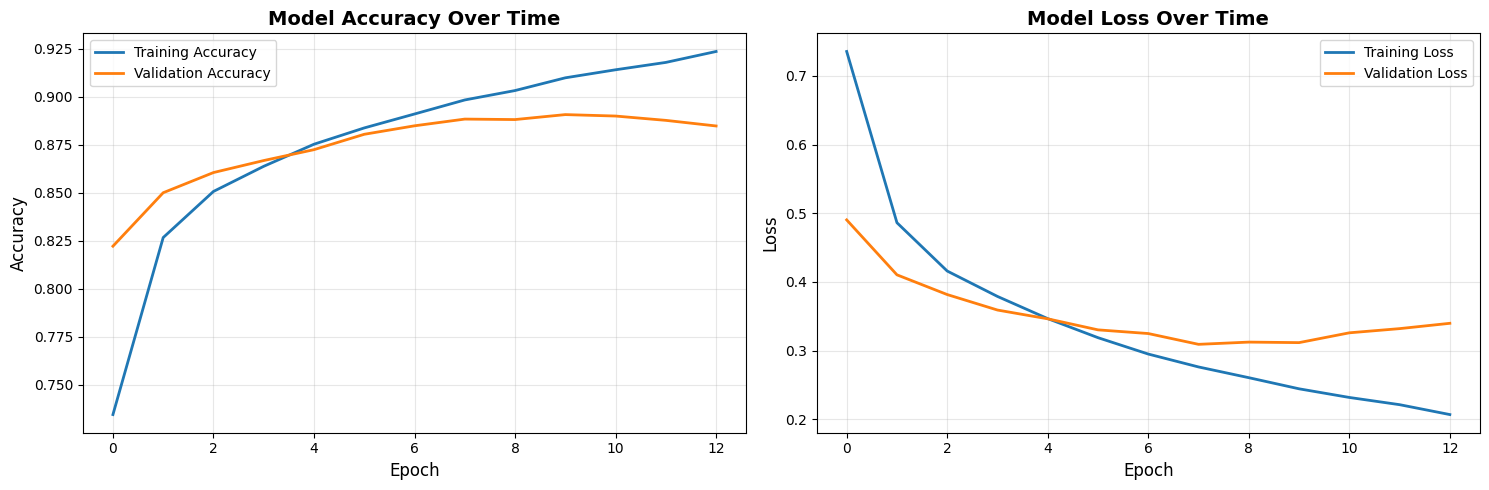


Final Training Metrics:
  Training Accuracy: 0.9235
  Validation Accuracy: 0.8848
  Training Loss: 0.2070
  Validation Loss: 0.3399

Overfitting Gap: 3.88%


In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Loss
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("\nFinal Training Metrics:")
print(f"  Training Accuracy: {final_train_acc:.4f}")
print(f"  Validation Accuracy: {final_val_acc:.4f}")
print(f"  Training Loss: {final_train_loss:.4f}")
print(f"  Validation Loss: {final_val_loss:.4f}")
print(f"\nOverfitting Gap: {(final_train_acc - final_val_acc)*100:.2f}%")

## Evaluate Model pada Test Set

Test set adalah data yang TIDAK PERNAH dilihat model selama training.
Ini adalah evaluasi paling objektif untuk performa model.

Metrics:
- Test Accuracy: overall performance
- Test Loss: confidence of predictions

Note: Test accuracy biasanya sedikit lebih rendah dari validation accuracy.
Ini normal karena model tidak pernah melihat data ini sama sekali.

In [45]:
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
print(f"Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss:      {test_loss:.4f}")
print("="*50)

# Compare dengan training dan validation
print("\nModel Performance Summary:")
print(f"  Training Accuracy:   {final_train_acc:.4f}")
print(f"  Validation Accuracy: {final_val_acc:.4f}")
print(f"  Test Accuracy:       {test_accuracy:.4f}")

# Analisis hasil
if test_accuracy >= 0.95:
    print("\n✓ Excellent performance! Model is working very well.")
elif test_accuracy >= 0.85:
    print("\n✓ Good performance! Model is reliable.")
elif test_accuracy >= 0.70:
    print("\n~ Decent performance. Consider model improvements.")
else:
    print("\n✗ Poor performance. Model needs significant improvements.")

Evaluating on test set...

TEST SET RESULTS
Test Accuracy:  0.8846 (88.46%)
Test Loss:      0.3262

Model Performance Summary:
  Training Accuracy:   0.9235
  Validation Accuracy: 0.8848
  Test Accuracy:       0.8846

✓ Good performance! Model is reliable.


## Make Predictions

Sekarang kita gunakan model untuk prediksi pada test data.

Output dari model.predict():
- Array of probabilities untuk setiap kelas
- Shape: (num_samples, num_classes)
- Sum dari probabilities = 1.0

np.argmax():
- Mengambil index dengan nilai tertinggi
- Index ini adalah predicted class

In [46]:
print("Making predictions on test set...")
y_pred_proba = model.predict(X_test, verbose=0)  # Probabilities
y_pred = np.argmax(y_pred_proba, axis=1)         # Predicted classes

print(f"Predictions shape: {y_pred_proba.shape}")
print(f"Predicted classes shape: {y_pred.shape}")

# Show example predictions
print("\nExample predictions (first 10 samples):")
print("-" * 70)
print(f"{'Index':<8} {'True Label':<15} {'Predicted':<15} {'Confidence':<12}")
print("-" * 70)

for i in range(10):
    true_label = class_names[y_test[i]]
    pred_label = class_names[y_pred[i]]
    confidence = y_pred_proba[i][y_pred[i]] * 100
    
    # Tambahkan emoji untuk benar/salah
    status = "✓" if y_test[i] == y_pred[i] else "✗"
    
    print(f"{i:<8} {true_label:<15} {pred_label:<15} {confidence:>6.2f}%  {status}")

print("-" * 70)

# Calculate accuracy manually (untuk verifikasi)
correct_predictions = np.sum(y_pred == y_test)
manual_accuracy = correct_predictions / len(y_test)
print(f"\nManual accuracy calculation: {correct_predictions}/{len(y_test)} = {manual_accuracy:.4f}")
print(f"Model.evaluate accuracy:     {test_accuracy:.4f}")
print(f"Difference:                  {abs(manual_accuracy - test_accuracy):.6f} (should be ~0)")

Making predictions on test set...
Predictions shape: (10000, 10)
Predicted classes shape: (10000,)

Example predictions (first 10 samples):
----------------------------------------------------------------------
Index    True Label      Predicted       Confidence  
----------------------------------------------------------------------
0        Ankle boot      Ankle boot       99.74%  ✓
1        Pullover        Pullover         99.81%  ✓
2        Trouser         Trouser         100.00%  ✓
3        Trouser         Trouser         100.00%  ✓
4        Shirt           Shirt            77.07%  ✓
5        Trouser         Trouser         100.00%  ✓
6        Coat            Coat             99.29%  ✓
7        Shirt           Shirt            81.07%  ✓
8        Sandal          Sandal          100.00%  ✓
9        Sneaker         Sneaker         100.00%  ✓
----------------------------------------------------------------------

Manual accuracy calculation: 8846/10000 = 0.8846
Model.evaluate accuracy

## Confusion Matrix

Confusion matrix menunjukkan:
- Baris: True labels
- Kolom: Predicted labels
- Diagonal: Correct predictions
- Off-diagonal: Misclassifications

Dari matrix ini kita bisa lihat:
- Class mana yang sering salah prediksi
- Class mana yang sering tertukar
- Pattern kesalahan model

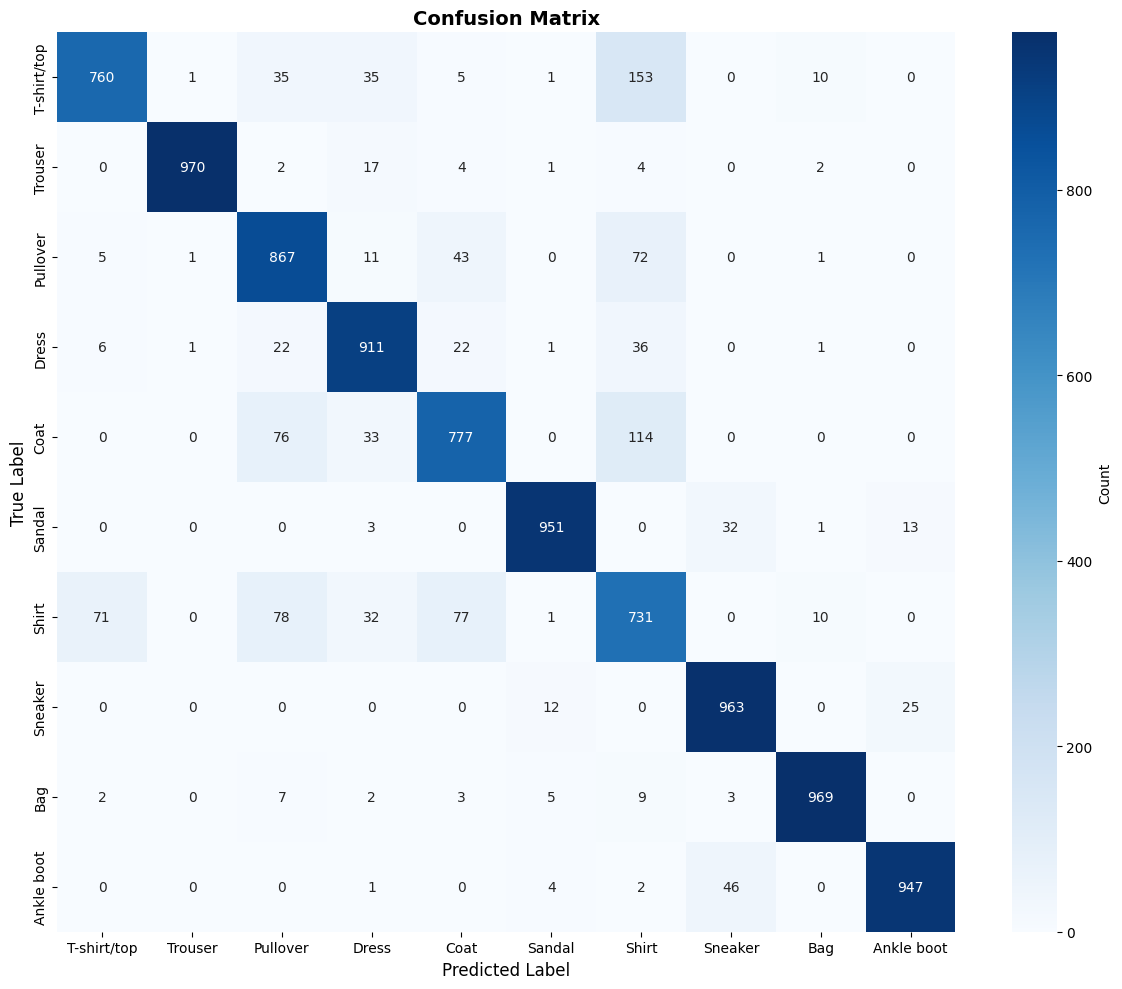


Confusion Matrix Analysis:
--------------------------------------------------
T-shirt/top    :  760/1000 = 0.760 (76.0%)
Trouser        :  970/1000 = 0.970 (97.0%)
Pullover       :  867/1000 = 0.867 (86.7%)
Dress          :  911/1000 = 0.911 (91.1%)
Coat           :  777/1000 = 0.777 (77.7%)
Sandal         :  951/1000 = 0.951 (95.1%)
Shirt          :  731/1000 = 0.731 (73.1%)
Sneaker        :  963/1000 = 0.963 (96.3%)
Bag            :  969/1000 = 0.969 (96.9%)
Ankle boot     :  947/1000 = 0.947 (94.7%)

Most Common Misclassifications:
--------------------------------------------------
  T-shirt/top → Shirt: 153 times
  Coat → Shirt: 114 times
  Shirt → Pullover: 78 times
  Shirt → Coat: 77 times
  Coat → Pullover: 76 times


In [47]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Analisis confusion matrix
print("\nConfusion Matrix Analysis:")
print("-" * 50)

# Per-class accuracy
for i in range(len(class_names)):
    class_total = cm[i].sum()
    class_correct = cm[i][i]
    class_accuracy = class_correct / class_total if class_total > 0 else 0
    print(f"{class_names[i]:<15}: {class_correct:>4}/{class_total:<4} = {class_accuracy:.3f} ({class_accuracy*100:.1f}%)")

# Find most confused pairs
print("\nMost Common Misclassifications:")
print("-" * 50)
misclassifications = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i][j] > 0:
            misclassifications.append((class_names[i], class_names[j], cm[i][j]))

# Sort by count
misclassifications.sort(key=lambda x: x[2], reverse=True)

# Show top 5
for true_label, pred_label, count in misclassifications[:5]:
    print(f"  {true_label} → {pred_label}: {count} times")

## Detailed Classification Report

Metrics untuk setiap class:

1. **Precision**: Dari semua prediksi class X, berapa yang benar?
   - High precision = sedikit false positives
   
2. **Recall**: Dari semua sampel class X, berapa yang terdeteksi?
   - High recall = sedikit false negatives
   
3. **F1-Score**: Harmonic mean dari precision dan recall
   - Balanced metric antara precision dan recall
   
4. **Support**: Jumlah sampel sebenarnya untuk class tersebut

In [48]:
# Generate classification report
report = classification_report(y_test, y_pred, 
                               target_names=class_names,
                               digits=4)

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(report)

# Detailed explanation
print("\nMetrics Explanation:")
print("-" * 70)
print("Precision: Ketepatan prediksi positif")
print("           = True Positives / (True Positives + False Positives)")
print("\nRecall:    Kemampuan menemukan semua positif")
print("           = True Positives / (True Positives + False Negatives)")
print("\nF1-Score:  Harmonic mean dari Precision dan Recall")
print("           = 2 * (Precision * Recall) / (Precision + Recall)")
print("\nSupport:   Jumlah sampel sebenarnya di test set")
print("-" * 70)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

 T-shirt/top     0.9005    0.7600    0.8243      1000
     Trouser     0.9969    0.9700    0.9833      1000
    Pullover     0.7976    0.8670    0.8309      1000
       Dress     0.8718    0.9110    0.8910      1000
        Coat     0.8346    0.7770    0.8048      1000
      Sandal     0.9744    0.9510    0.9626      1000
       Shirt     0.6521    0.7310    0.6893      1000
     Sneaker     0.9224    0.9630    0.9423      1000
         Bag     0.9748    0.9690    0.9719      1000
  Ankle boot     0.9614    0.9470    0.9542      1000

    accuracy                         0.8846     10000
   macro avg     0.8887    0.8846    0.8854     10000
weighted avg     0.8887    0.8846    0.8854     10000


Metrics Explanation:
----------------------------------------------------------------------
Precision: Ketepatan prediksi positif
           = True Positives / (True Positives + False Positives)

Recall:    Kemampuan 

## Visualisasi Predictions

Kita akan visualisasi:
1. Correct predictions dengan confidence tertinggi
2. Incorrect predictions (untuk analisis error)

Ini membantu kita memahami:
- Kapan model confident dan benar
- Kapan model salah dan kenapa
- Pattern kesalahan yang mungkin bisa diperbaiki

Visualizing CORRECT predictions (high confidence)...


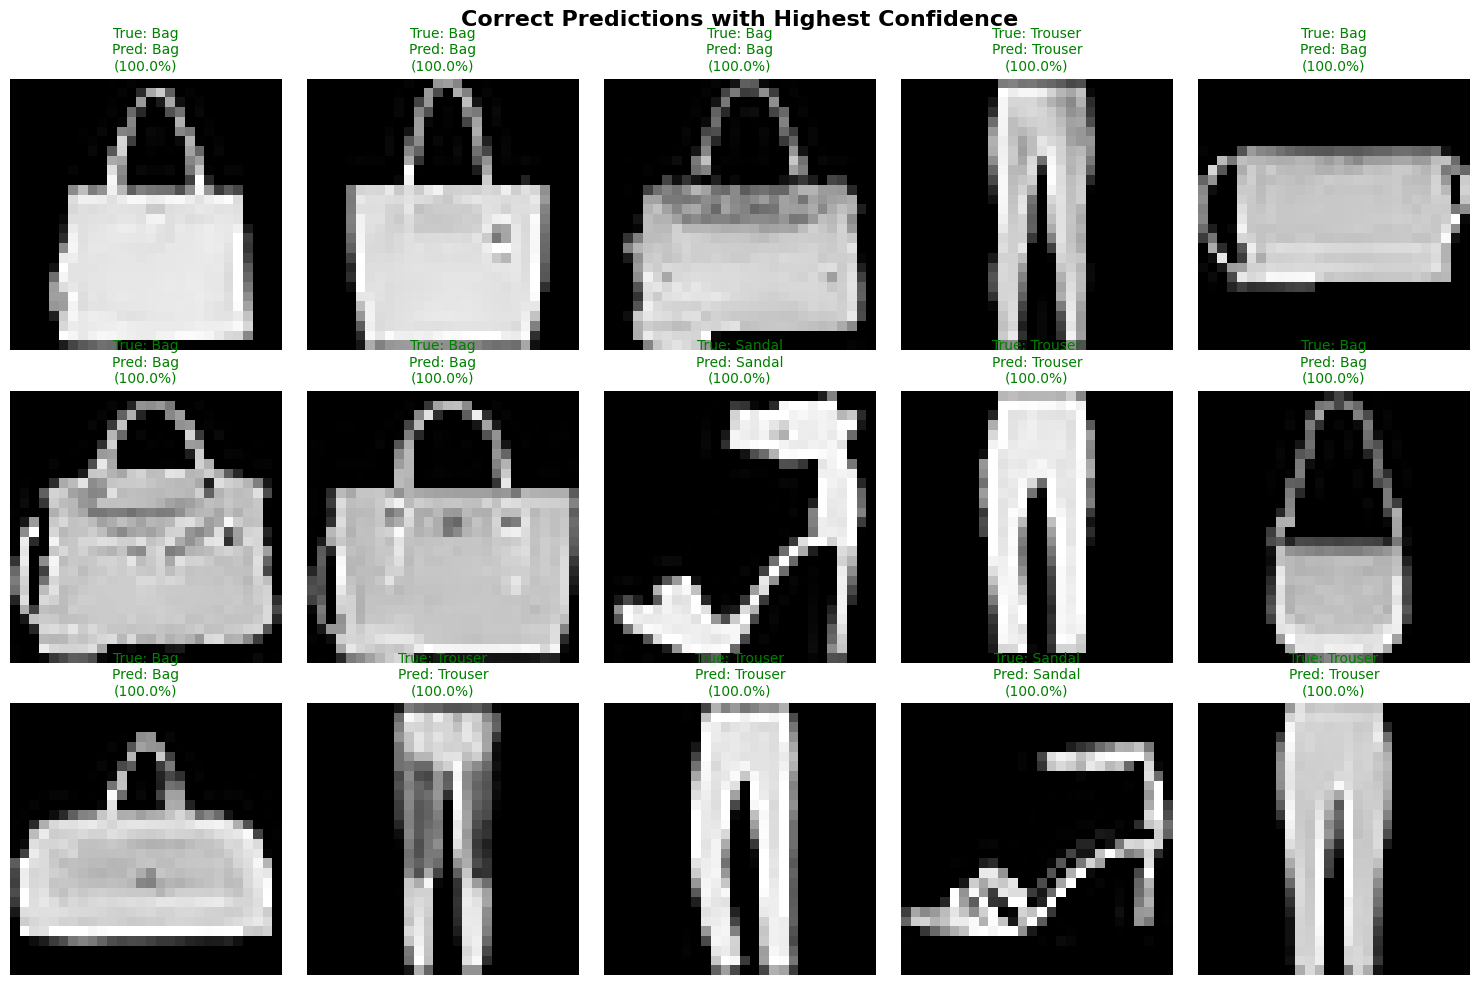


Visualizing INCORRECT predictions...


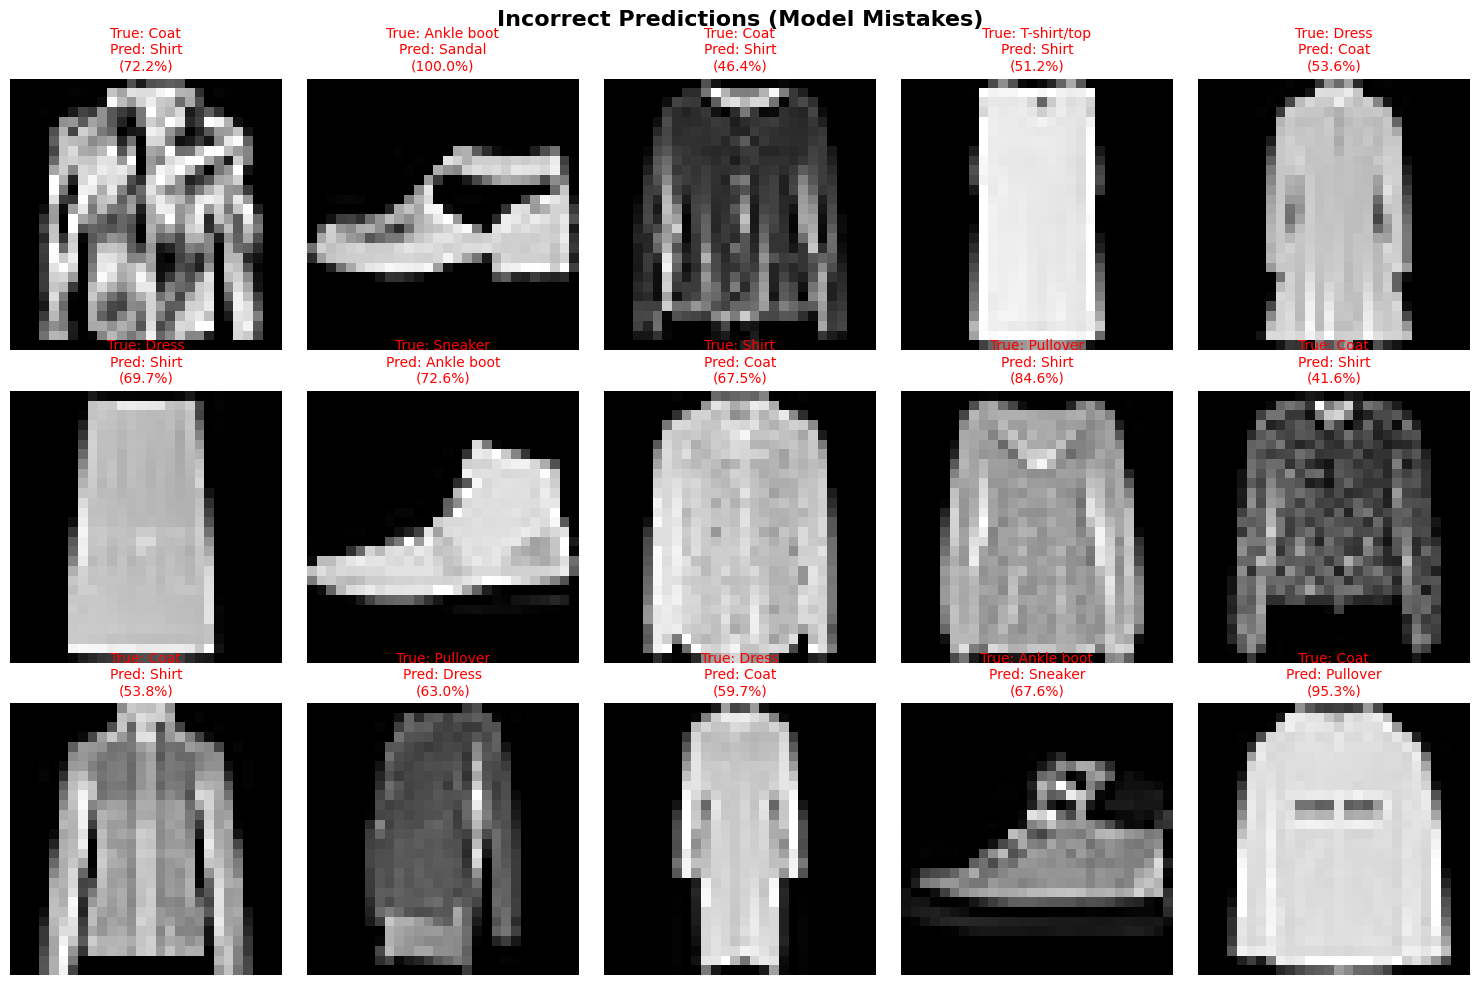


Total incorrect predictions: 1154
Error rate: 11.54%


In [49]:
# Function to display predictions
def plot_predictions(images, true_labels, pred_labels, pred_probs, 
                     title, num_images=15, figsize=(15, 10)):
    """Plot predictions dengan confidence scores"""
    num_rows = (num_images + 4) // 5
    fig, axes = plt.subplots(num_rows, 5, figsize=figsize)
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            ax.axis('off')
            continue
            
        # Plot image
        if images[i].shape[-1] == 1:  # Grayscale
            ax.imshow(images[i].squeeze(), cmap='gray')
        else:  # RGB
            ax.imshow(images[i])
        
        # Get labels and confidence
        true_label = class_names[true_labels[i]]
        pred_label = class_names[pred_labels[i]]
        confidence = pred_probs[i][pred_labels[i]] * 100
        
        # Color code: green if correct, red if wrong
        color = 'green' if true_labels[i] == pred_labels[i] else 'red'
        
        # Set title
        ax.set_title(f'True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)', 
                     fontsize=10, color=color)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Find correct predictions with high confidence
correct_mask = y_test == y_pred
correct_indices = np.where(correct_mask)[0]
correct_confidences = np.max(y_pred_proba[correct_indices], axis=1)
top_correct_indices = correct_indices[np.argsort(correct_confidences)[-15:]]

print("Visualizing CORRECT predictions (high confidence)...")
plot_predictions(X_test[top_correct_indices], 
                y_test[top_correct_indices],
                y_pred[top_correct_indices],
                y_pred_proba[top_correct_indices],
                'Correct Predictions with Highest Confidence')

# Find incorrect predictions
incorrect_mask = y_test != y_pred
incorrect_indices = np.where(incorrect_mask)[0][:15]

if len(incorrect_indices) > 0:
    print("\nVisualizing INCORRECT predictions...")
    plot_predictions(X_test[incorrect_indices], 
                    y_test[incorrect_indices],
                    y_pred[incorrect_indices],
                    y_pred_proba[incorrect_indices],
                    'Incorrect Predictions (Model Mistakes)')
    
    print(f"\nTotal incorrect predictions: {len(np.where(incorrect_mask)[0])}")
    print(f"Error rate: {len(np.where(incorrect_mask)[0])/len(y_test)*100:.2f}%")
else:
    print("\nNo incorrect predictions! Perfect score! 🎉")

## Analisis Confidence Distribution

Confidence (probabilitas maksimum) menunjukkan seberapa yakin model:
- High confidence (>0.9): model sangat yakin
- Medium confidence (0.5-0.9): model cukup yakin
- Low confidence (<0.5): model ragu-ragu

Model yang baik:
- Confidence tinggi pada correct predictions
- Confidence rendah pada incorrect predictions

/tmp/ipykernel_1697984/2908065527.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(box_data, labels=['Correct', 'Incorrect'], patch_artist=True,


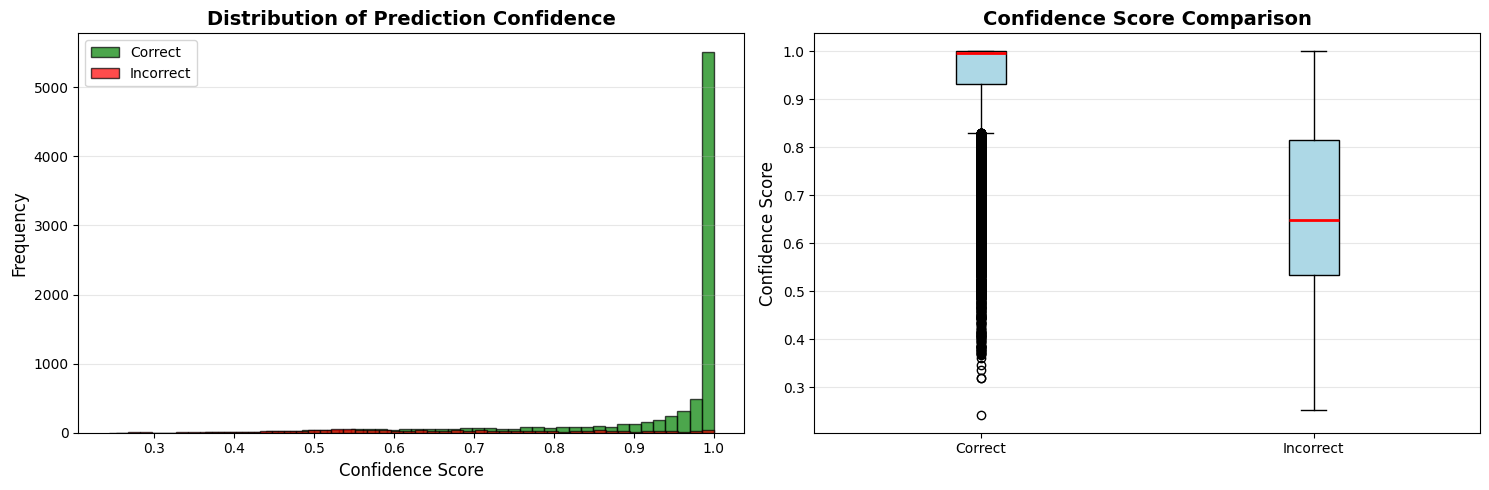

In [51]:
# Get max probabilities (confidence)
confidence_scores = np.max(y_pred_proba, axis=1)
correct_confidence = confidence_scores[y_test == y_pred]
incorrect_confidence = confidence_scores[y_test != y_pred]

# Plot confidence distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of all confidences
ax1.hist(correct_confidence, bins=50, alpha=0.7, label='Correct', color='green', edgecolor='black')
ax1.hist(incorrect_confidence, bins=50, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
ax1.set_xlabel('Confidence Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Prediction Confidence', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Box plot
box_data = [correct_confidence, incorrect_confidence]
ax2.boxplot(box_data, labels=['Correct', 'Incorrect'], patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red', linewidth=2))
ax2.set_ylabel('Confidence Score', fontsize=12)
ax2.set_title('Confidence Score Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [52]:

# Statistics
print("\nConfidence Statistics:")
print("="*50)
print(f"Correct Predictions:")
print(f"  Mean confidence:   {correct_confidence.mean():.4f}")
print(f"  Median confidence: {np.median(correct_confidence):.4f}")
print(f"  Min confidence:    {correct_confidence.min():.4f}")
print(f"  Max confidence:    {correct_confidence.max():.4f}")

if len(incorrect_confidence) > 0:
    print(f"\nIncorrect Predictions:")
    print(f"  Mean confidence:   {incorrect_confidence.mean():.4f}")
    print(f"  Median confidence: {np.median(incorrect_confidence):.4f}")
    print(f"  Min confidence:    {incorrect_confidence.min():.4f}")
    print(f"  Max confidence:    {incorrect_confidence.max():.4f}")
    
    print(f"\nConfidence Gap: {correct_confidence.mean() - incorrect_confidence.mean():.4f}")
    print("(Larger gap = model knows when it's uncertain)")


Confidence Statistics:
Correct Predictions:
  Mean confidence:   0.9293
  Median confidence: 0.9975
  Min confidence:    0.2436
  Max confidence:    1.0000

Incorrect Predictions:
  Mean confidence:   0.6706
  Median confidence: 0.6485
  Min confidence:    0.2532
  Max confidence:    1.0000

Confidence Gap: 0.2587
(Larger gap = model knows when it's uncertain)


## Predict on Single Image

Simulasi penggunaan model untuk prediksi single image baru.
Ini adalah workflow yang akan digunakan saat deployment.

Steps:
1. Load/prepare single image
2. Preprocess (normalize, reshape)
3. Predict
4. Interpret hasil

Testing with image index: 2454
True label: T-shirt/top


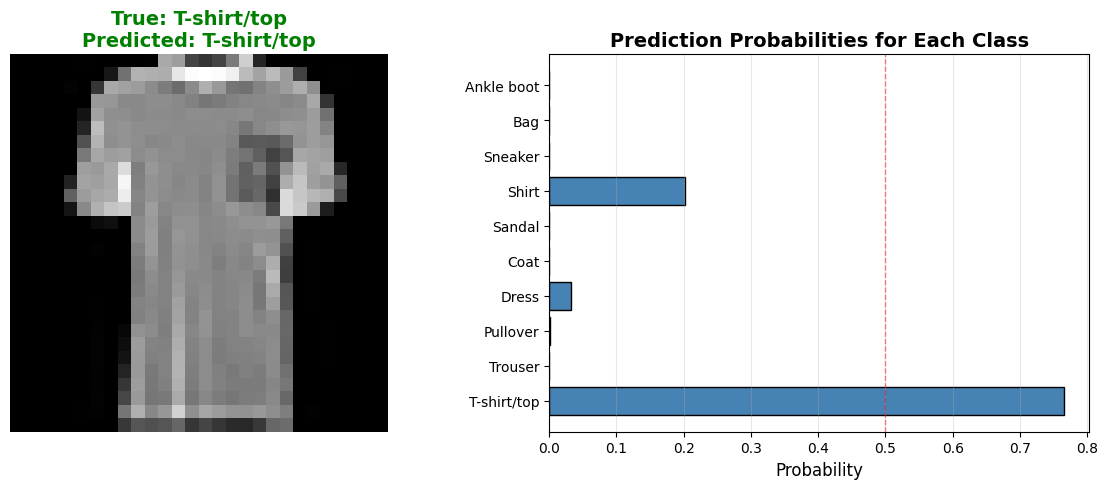

In [75]:
# Pilih random image dari test set
test_idx = np.random.randint(len(X_test))
single_image = X_test[test_idx]
true_label = y_test[test_idx]

print(f"Testing with image index: {test_idx}")
print(f"True label: {class_names[true_label]}")

# Predict (model expects batch, so add batch dimension)
single_image_batch = np.expand_dims(single_image, axis=0)
prediction_probs = model.predict(single_image_batch, verbose=0)[0]
predicted_class = np.argmax(prediction_probs)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Show image
if single_image.shape[-1] == 1:
    ax1.imshow(single_image.squeeze(), cmap='gray')
else:
    ax1.imshow(single_image)
    
color = 'green' if predicted_class == true_label else 'red'
ax1.set_title(f'True: {class_names[true_label]}\nPredicted: {class_names[predicted_class]}',
              fontsize=14, color=color, fontweight='bold')
ax1.axis('off')

# Show probability distribution
ax2.barh(class_names, prediction_probs, color='steelblue', edgecolor='black')
ax2.axvline(x=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Probability', fontsize=12)
ax2.set_title('Prediction Probabilities for Each Class', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [76]:
# Print detailed results
print("\n" + "="*50)
print("PREDICTION RESULTS")
print("="*50)
print(f"Predicted class: {class_names[predicted_class]}")
print(f"Confidence: {prediction_probs[predicted_class]*100:.2f}%")
print(f"Correct: {'YES ✓' if predicted_class == true_label else 'NO ✗'}")

print("\nTop 3 Predictions:")
top_3_idx = np.argsort(prediction_probs)[-3:][::-1]
for i, idx in enumerate(top_3_idx, 1):
    print(f"  {i}. {class_names[idx]}: {prediction_probs[idx]*100:.2f}%")


PREDICTION RESULTS
Predicted class: T-shirt/top
Confidence: 76.48%
Correct: YES ✓

Top 3 Predictions:
  1. T-shirt/top: 76.48%
  2. Shirt: 20.17%
  3. Dress: 3.27%


## Save Model

Menyimpan model untuk digunakan nanti tanpa perlu training ulang.

Format yang bisa disimpan:
1. .h5 file: entire model (architecture + weights + optimizer state)
2. SavedModel format: TensorFlow's native format
3. Weights only: hanya weights (.h5 atau checkpoint)

Untuk production, gunakan SavedModel format.

In [77]:
# Save full model (recommended)
model.save('saved_model/image_classifier_final.h5')
print("✓ Model saved as 'image_classifier_final.h5'")

# Save weights only
model.save_weights('saved_model/model_weights.weights.h5')
print("✓ Weights saved as 'model_weights.h5'")

# Save in SavedModel format
model.save('saved_model/image_model.h5',)
print("✓ Model saved in SavedModel format at 'saved_model/'")

print("\nModel saving completed!")
print("\nTo load model later:")
print("  from tensorflow.keras.models import load_model")
print("  model = load_model('image_classifier_final.h5')")

✓ Model saved as 'image_classifier_final.h5'
✓ Weights saved as 'model_weights.h5'
✓ Model saved in SavedModel format at 'saved_model/'

Model saving completed!

To load model later:
  from tensorflow.keras.models import load_model
  model = load_model('image_classifier_final.h5')


## Load Saved Model

Verifikasi bahwa model yang disimpan bisa di-load kembali
dan memberikan hasil yang sama.

In [78]:
from tensorflow.keras.models import load_model

# Load model
print("Loading saved model...")
loaded_model = load_model('saved_model/image_classifier_final.h5')
print("✓ Model loaded successfully!")

# Test pada beberapa sample
print("\nTesting loaded model...")
test_samples = X_test[:100]
test_labels = y_test[:100]

Loading saved model...
✓ Model loaded successfully!

Testing loaded model...


In [79]:
# Predict with original model
original_predictions = model.predict(test_samples, verbose=0)

# Predict with loaded model
loaded_predictions = loaded_model.predict(test_samples, verbose=0)

# Compare
are_equal = np.allclose(original_predictions, loaded_predictions)
print(f"\nPredictions match: {are_equal}")

if are_equal:
    print("✓ Loaded model works correctly!")
else:
    print("✗ Warning: Predictions don't match!")
    print(f"Max difference: {np.max(np.abs(original_predictions - loaded_predictions))}")


Predictions match: True
✓ Loaded model works correctly!


## Model Summary and Next Steps

Ringkasan hasil dan rekomendasi untuk improvement.

In [80]:
print("\n" + "="*70)
print("                    MODEL PERFORMANCE SUMMARY")
print("="*70)
print(f"\nDataset: {x_train.shape[1:-1]} images")
print(f"Classes: {len(class_names)}")
print(f"Architecture: {'CNN' if 'conv' in [layer.name for layer in model.layers][0] else 'FNN'}")
print(f"Total Parameters: {model.count_params():,}")

print(f"\nTraining Results:")
print(f"  Final Training Accuracy:   {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"  Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"  Test Accuracy:             {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print(f"\nPrediction Confidence:")
print(f"  Correct predictions:   {correct_confidence.mean():.4f} (avg)")
if len(incorrect_confidence) > 0:
    print(f"  Incorrect predictions: {incorrect_confidence.mean():.4f} (avg)")
    



                    MODEL PERFORMANCE SUMMARY

Dataset: (28, 28) images
Classes: 10
Architecture: CNN
Total Parameters: 110,474

Training Results:
  Final Training Accuracy:   0.9235 (92.35%)
  Final Validation Accuracy: 0.8848 (88.48%)
  Test Accuracy:             0.8846 (88.46%)

Prediction Confidence:
  Correct predictions:   0.9293 (avg)
  Incorrect predictions: 0.6706 (avg)


In [81]:
print("\n" + "="*70)
print("NEXT STEPS TO IMPROVE MODEL:")
print("="*70)

# Recommendations based on performance
if test_accuracy < 0.85:
    print("\n1. Model Architecture:")
    print("   - Try deeper CNN with more Conv layers")
    print("   - Increase number of filters (32 → 64 → 128)")
    print("   - Add Batch Normalization layers")
    
    print("\n2. Data:")
    print("   - Add data augmentation (rotation, flip, zoom)")
    print("   - Collect more training data")
    print("   - Check for data quality issues")
    
    print("\n3. Training:")
    print("   - Train longer (more epochs)")
    print("   - Try different learning rates")
    print("   - Use learning rate scheduler")

elif test_accuracy < 0.95:
    print("\n1. Fine-tuning:")
    print("   - Use learning rate scheduler")
    print("   - Add data augmentation")
    print("   - Try ensemble methods")
    
    print("\n2. Architecture:")
    print("   - Add more layers or neurons")
    print("   - Experiment with different activation functions")
    
else:
    print("\n✓ Excellent performance! Consider:")
    print("   - Transfer learning with pre-trained models")
    print("   - Deploy to production")
    print("   - Try more challenging datasets")
    



NEXT STEPS TO IMPROVE MODEL:

1. Fine-tuning:
   - Use learning rate scheduler
   - Add data augmentation
   - Try ensemble methods

2. Architecture:
   - Add more layers or neurons
   - Experiment with different activation functions


In [82]:
print("\n4. Advanced Techniques:")
print("   - Transfer Learning (VGG16, ResNet, MobileNet)")
print("   - Hyperparameter tuning (Grid Search, Random Search)")
print("   - Cross-validation for more robust evaluation")
print("   - Try different optimizers (SGD with momentum, RMSprop)")

print("\n5. Deployment:")
print("   - Convert to TensorFlow Lite for mobile")
print("   - Use TensorFlow Serving for API")
print("   - Optimize model size (pruning, quantization)")

print("\n" + "="*70)
print("                    HAPPY LEARNING! 🚀")
print("="*70)


4. Advanced Techniques:
   - Transfer Learning (VGG16, ResNet, MobileNet)
   - Hyperparameter tuning (Grid Search, Random Search)
   - Cross-validation for more robust evaluation
   - Try different optimizers (SGD with momentum, RMSprop)

5. Deployment:
   - Convert to TensorFlow Lite for mobile
   - Use TensorFlow Serving for API
   - Optimize model size (pruning, quantization)

                    HAPPY LEARNING! 🚀


## BONUS: Data Augmentation

Data augmentation adalah teknik untuk memperbanyak data training
dengan membuat variasi dari gambar yang ada.

Benefits:
- Mencegah overfitting
- Meningkatkan generalisasi model
- Membuat model lebih robust

Transformations:
- Rotation: putar gambar
- Width/Height shift: geser posisi
- Zoom: perbesar/perkecil
- Horizontal flip: balik horizontal

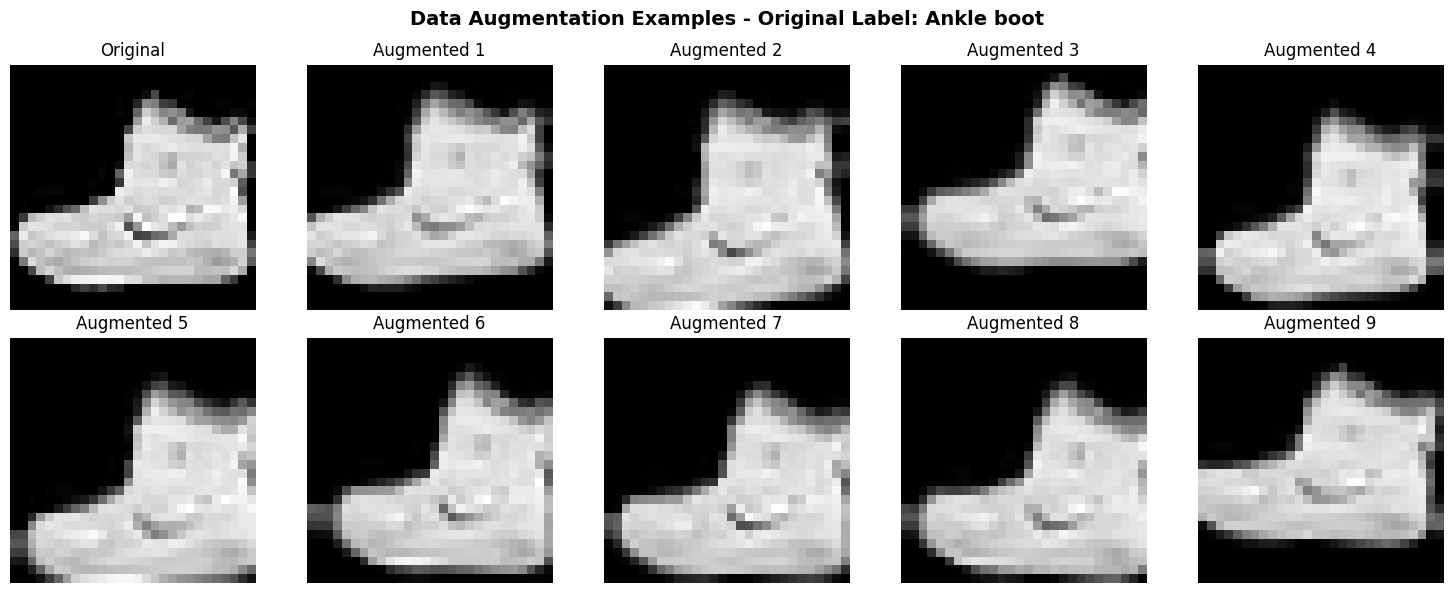


Data Augmentation Configuration:
  Rotation range: 10°
  Width shift: 10.0%
  Height shift: 10.0%
  Zoom range: [0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1.1, 0.9, 1

In [83]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,        # Rotate up to 10 degrees
    width_shift_range=0.1,    # Shift horizontally by 10%
    height_shift_range=0.1,   # Shift vertically by 10%
    zoom_range=0.1,           # Zoom by 10%
    horizontal_flip=False,    # Set True for images (not digits)
    fill_mode='nearest'       # How to fill empty pixels
)

# Visualize augmented images
sample_image = x_train[0:1]  # Take one image
sample_label = class_names[y_train[0]]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle(f'Data Augmentation Examples - Original Label: {sample_label}', 
             fontsize=14, fontweight='bold')

# Show original
if sample_image.shape[-1] == 1:
    axes[0, 0].imshow(sample_image[0].squeeze(), cmap='gray')
else:
    axes[0, 0].imshow(sample_image[0])
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

# Generate and show augmented versions
aug_iter = datagen.flow(sample_image, batch_size=1)
for i in range(9):
    augmented_image = next(aug_iter)[0]
    row = (i + 1) // 5
    col = (i + 1) % 5
    
    if augmented_image.shape[-1] == 1:
        axes[row, col].imshow(augmented_image.squeeze(), cmap='gray')
    else:
        axes[row, col].imshow(augmented_image)
    axes[row, col].set_title(f'Augmented {i+1}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("\nData Augmentation Configuration:")
print(f"  Rotation range: {datagen.rotation_range}°")
print(f"  Width shift: {datagen.width_shift_range*100}%")
print(f"  Height shift: {datagen.height_shift_range*100}%")
print(f"  Zoom range: {datagen.zoom_range*100}%")
print(f"  Horizontal flip: {datagen.horizontal_flip}")

print("\nTo use in training:")
print("  model.fit(datagen.flow(X_train, y_train, batch_size=32),")
print("            epochs=20, validation_data=(X_val, y_val))")

## BONUS: Transfer Learning

Transfer learning menggunakan model yang sudah di-train pada dataset besar
(seperti ImageNet) sebagai starting point.

Benefits:
- Training lebih cepat
- Performa lebih baik dengan data lebih sedikit
- Bisa mencapai state-of-the-art results

Popular pre-trained models:
- VGG16, VGG19: deep CNN, akurat tapi berat
- ResNet50, ResNet101: very deep dengan skip connections
- MobileNet: lightweight, cocok untuk mobile
- EfficientNet: balance accuracy dan efficiency

In [84]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

print("Creating Transfer Learning Model...")
print("Using MobileNetV2 pre-trained on ImageNet")

# Note: MobileNetV2 expects input size (96, 96, 3) or larger
# For MNIST/Fashion-MNIST, this is just for demonstration

# Load pre-trained model (without top classification layer)
base_model = MobileNetV2(
    input_shape=(96, 96, 3),  # Minimum size for MobileNetV2
    include_top=False,         # Remove classification layer
    weights='imagenet'         # Use ImageNet weights
)

# Freeze base model layers (don't train them)
base_model.trainable = False

# Add custom classification layers
transfer_model = models.Sequential([
    # Base model
    base_model,
    
    # Custom layers
    GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile
transfer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Show architecture
print("\nTransfer Learning Model Summary:")
print(f"  Base model: MobileNetV2")
print(f"  Trainable parameters: {sum([tf.size(w).numpy() for w in transfer_model.trainable_weights]):,}")
print(f"  Non-trainable parameters: {sum([tf.size(w).numpy() for w in transfer_model.non_trainable_weights]):,}")
print(f"  Total parameters: {transfer_model.count_params():,}")

print("\nNote: For actual use, you need to:")
print("  1. Resize images to minimum (96, 96, 3)")
print("  2. Convert grayscale to RGB if needed")
print("  3. Preprocess with appropriate function")
print("  4. Train with same workflow as before")

print("\nExample preprocessing:")
print("  from tensorflow.keras.applications.mobilenet_v2 import preprocess_input")
print("  X_train_processed = preprocess_input(X_train_resized)")

Creating Transfer Learning Model...
Using MobileNetV2 pre-trained on ImageNet

Transfer Learning Model Summary:
  Base model: MobileNetV2
  Trainable parameters: 165,258
  Non-trainable parameters: 2,257,984
  Total parameters: 2,423,242

Note: For actual use, you need to:
  1. Resize images to minimum (96, 96, 3)
  2. Convert grayscale to RGB if needed
  3. Preprocess with appropriate function
  4. Train with same workflow as before

Example preprocessing:
  from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
  X_train_processed = preprocess_input(X_train_resized)
